# Ego4D dataset analysis

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
%matplotlib inline

In [ ]:
ann_data = json.load(open("nlq_train.json"))

In [ ]:
# please see https://ego4d-data.org/docs/data/annotations-schemas/

anns = []
for vid in ann_data["videos"]:
    for clip in vid["clips"]:
        for ann in clip["annotations"]:
            for query in ann["language_queries"]:
                anns.append({
                    "query_start_time_sec": clip["video_start_sec"],
                    "query_end_time_sec": clip["video_end_sec"],
                    "query_response_start_time_sec": query["video_start_sec"],
                    "query_response_end_time_sec": query["video_end_sec"],
                    "query_template": query.get("template", None),
                    "query": query.get("query", None),
                })

In [ ]:
num_queries = len(anns)
relative_query_sizes = np.array([
    (a["query_response_end_time_sec"] - a["query_response_start_time_sec"]) / (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])
query_sizes = np.array([
    (a["query_response_end_time_sec"] - a["query_response_start_time_sec"])
    for a in anns
])
clip_sizes = np.array([
    (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])

## Query / Response Durations

Here we can see that there are some queries with 0s. When training it is reccomended to remove them from the set. For VSLNet you can provide `--remove_empty_queries_from train` to `main.py` (e.g. if you are modifying this codebase).

In [ ]:
query_sizes.max(), query_sizes.min(), query_sizes.std()

(480.0, 0.0, 22.82781402544118)

In [ ]:
# less than or equal to 4 frames => 9% of training data
(query_sizes <= 4/30).sum() / len(relative_query_sizes)

0.09012039660056657

## Distribution of Queries (relative)

In [ ]:
plt.rcParams["figure.figsize"] = (16, 9)

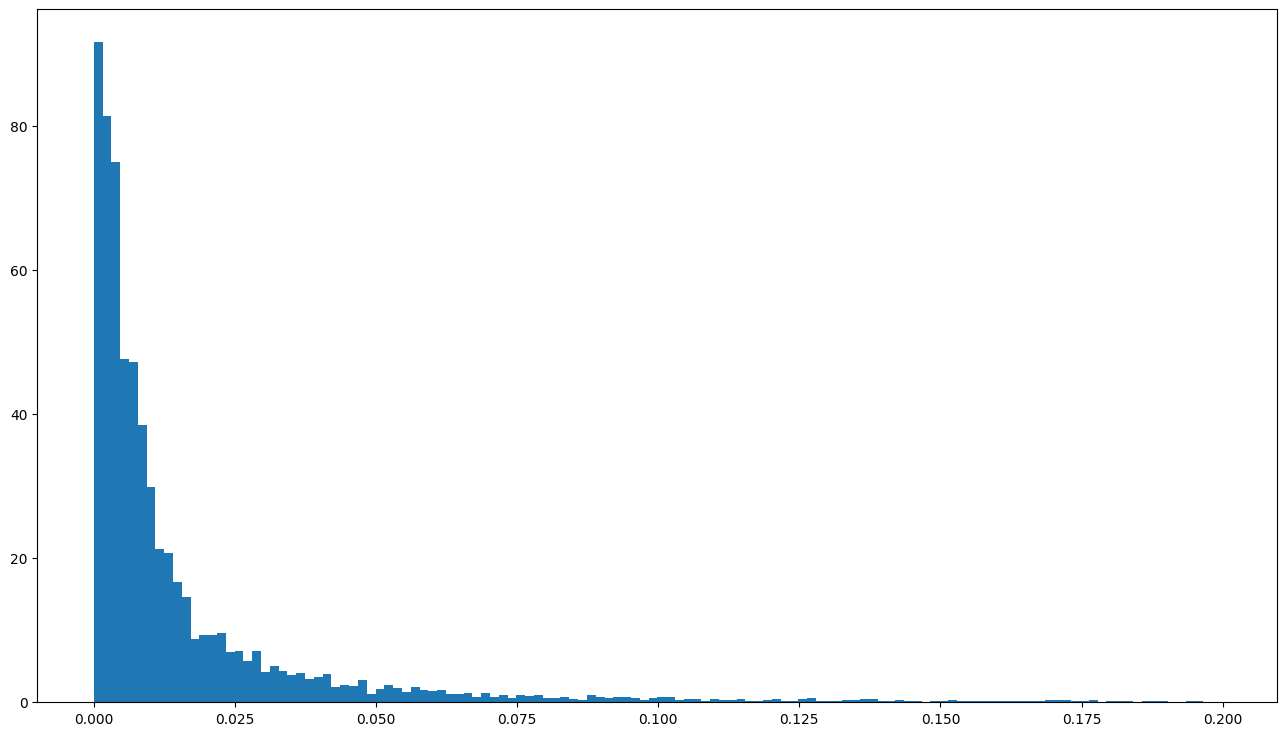

In [ ]:
plt.hist(relative_query_sizes[relative_query_sizes < 0.2], density=True, bins=128)
plt.show()

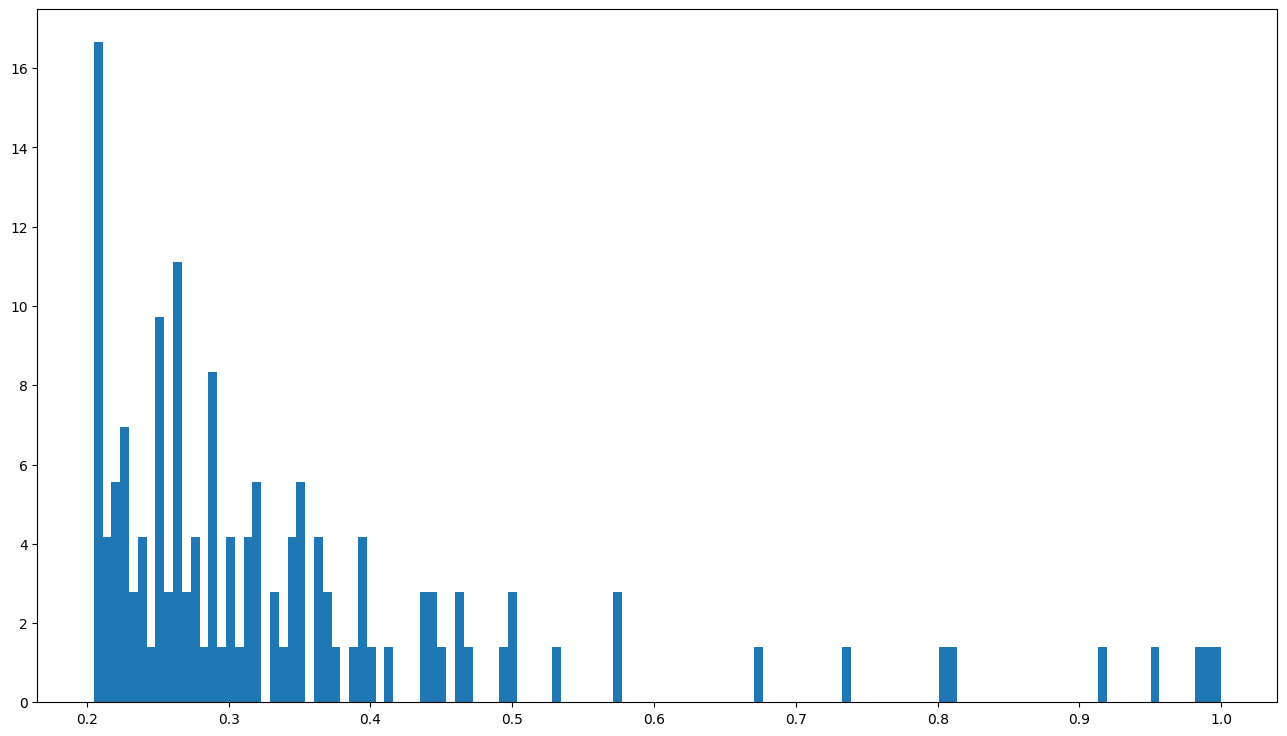

In [ ]:
plt.hist(relative_query_sizes[relative_query_sizes > 0.2], density=True, bins=128)
plt.show()

## Clip Sizes

Clips are 522s on average, with most clips being 480s.

In [ ]:
clip_sizes.mean(), clip_sizes.max(), clip_sizes.min(), clip_sizes.std(), np.median(clip_sizes)

(522.6759852928087,
 1200.0666422526042,
 207.16666666666674,
 197.6377591205408,
 480.0)

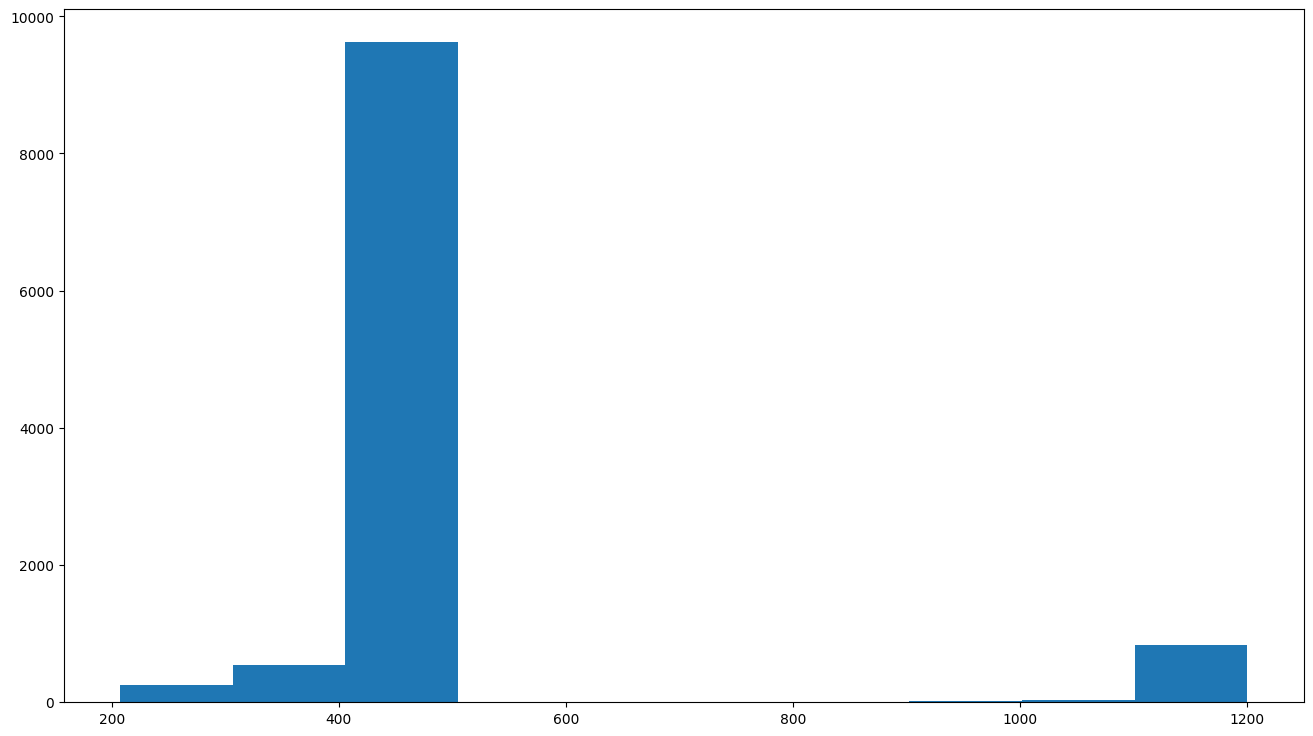

In [ ]:
plt.hist(clip_sizes)
plt.show()

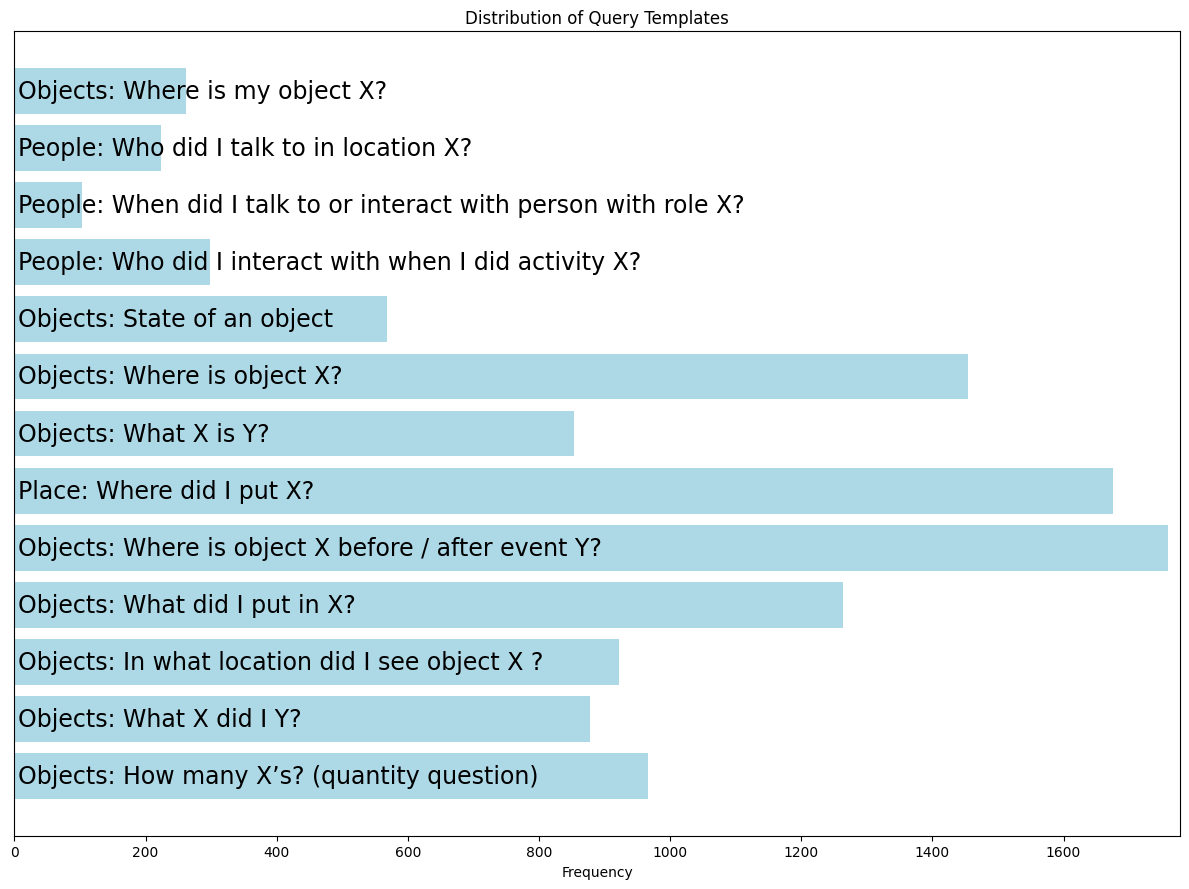

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each template
template_counts = Counter(a['query_template'] for a in anns if a['query_template'] is not None)

# Plot the distribution of query templates with light blue bars
plt.figure(figsize=(12, 9))
bars = plt.barh(list(template_counts.keys()), template_counts.values(), color='lightblue')  # Set color to light blue
plt.xlabel('Frequency')
plt.title('Distribution of Query Templates')

# Add text labels (the y-axis labels) inside the bars with larger font size
for bar, label in zip(bars, template_counts.keys()):
    width = bar.get_width()  # Get the width (value) of the bar
    plt.text(5,  # Smaller padding from the left side of the bar to reduce empty space
             bar.get_y() + bar.get_height() / 2,  # Center vertically within the bar
             label,  # Use the label (query template)
             va='center',  # Center alignment vertically
             ha='left',  # Align text to the left inside the bar
             color='black',  # Change text color to black
             fontsize=17)  # Increase font size by two points

# Adjust the x-axis limits to more closely fit the data
plt.xlim(0, max(template_counts.values()) * 1.01)  # Adjust the limit to 5% more than the max value

plt.yticks([])  # Remove the original y-axis labels since we put them inside the bars
plt.tight_layout()  # Ensure the layout fits well
plt.show()


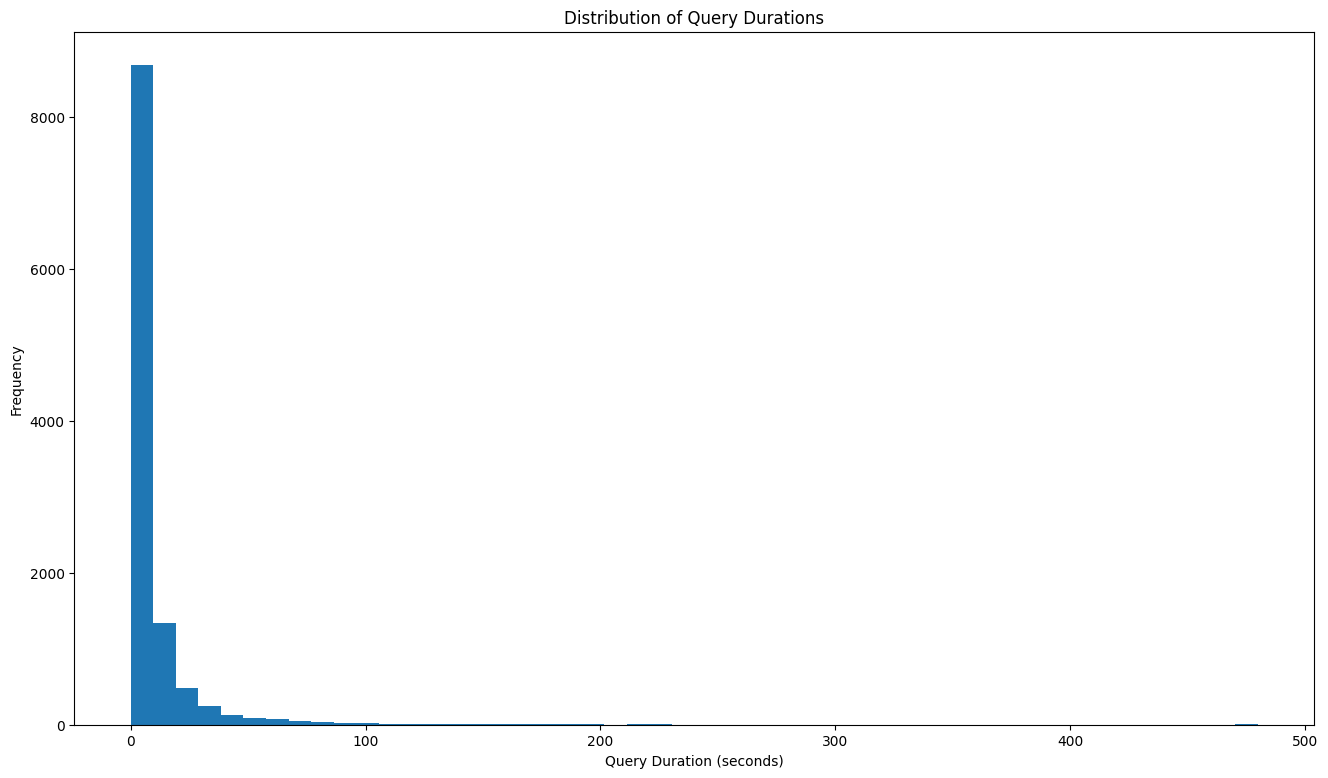

In [ ]:
# Plot the distribution of query durations
plt.figure(figsize=(16, 9))
plt.hist(query_sizes, bins=50)
plt.xlabel('Query Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Query Durations')
plt.show()

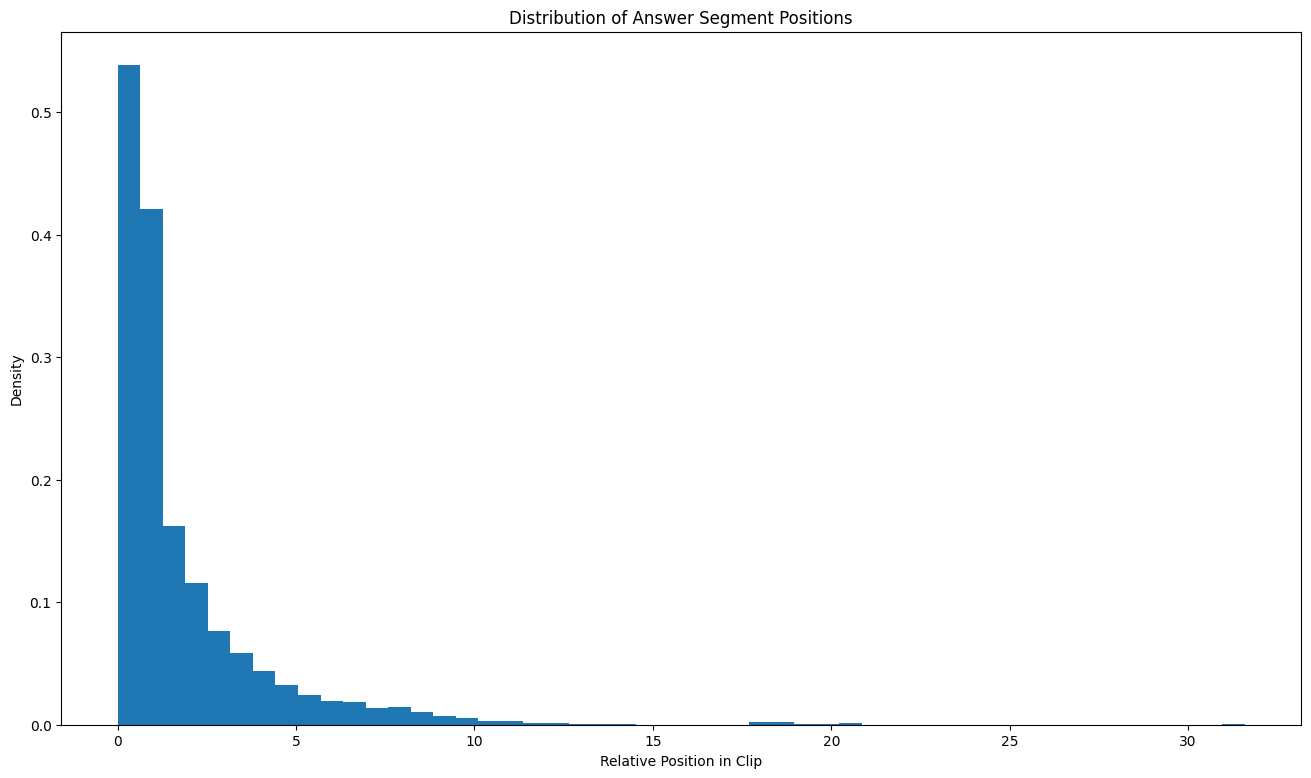

In [ ]:
# Calculate the position of answer segments within the clips
answer_segment_positions = np.array([
    (a["query_response_start_time_sec"] + a["query_response_end_time_sec"]) / 2 / (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])

# Plot the distribution of answer segment positions
plt.figure(figsize=(16, 9))
plt.hist(answer_segment_positions, bins=50, density=True)
plt.xlabel('Relative Position in Clip')
plt.ylabel('Density')
plt.title('Distribution of Answer Segment Positions')
plt.show()


In [ ]:
# Create a DataFrame for statistical summary
df = pd.DataFrame({
    'query_size': query_sizes,
    'clip_size': clip_sizes,
    'relative_query_size': relative_query_sizes
})

# Calculate summary statistics
summary_stats = df.describe()

# Calculate kurtosis and skewness
kurtosis = df.kurtosis()
skewness = df.skew()

# Add kurtosis and skewness to the summary statistics DataFrame
summary_stats.loc['kurtosis'] = kurtosis
summary_stats.loc['skewness'] = skewness

# Display summary statistics
print(summary_stats)


            query_size     clip_size  relative_query_size
count     11296.000000  11296.000000         11296.000000
mean          9.670475    522.675985             0.019533
std          22.828825    197.646508             0.046186
min           0.000000    207.166667             0.000000
25%           1.465605    480.000000             0.002867
50%           3.454305    480.000000             0.006958
75%           8.739587    480.036674             0.017365
max         480.000000   1200.066642             0.999924
kurtosis    114.246426      7.381792           126.642860
skewness      8.527831      2.950752             8.878163
